In [6]:
#--Daten Import
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. CSV-Datei laden (korrekter Pfad & Komma als Trennzeichen) ===
file_path = 'data/raw/rel_gemeinde.csv'
df = pd.read_csv(file_path, sep=",", encoding="utf-8")

      Unnamed: 0  Regions_ID         Regionsname  \
0              1           2  Affoltern am Albis   
1              2           3          Bonstetten   
2              3           5            Hedingen   
3              4           7              Knonau   
4              5           8         Maschwanden   
...          ...         ...                 ...   
2116        2117        6808                 NaN   
2117        2118        6809                 NaN   
2118        2119        6810                 NaN   
2119        2120        6811                 NaN   
2120        2121        6812                 NaN   

                             y_1850                         y_1860  \
0     Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
1     Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
2     Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
3     Mehrheit reformiert: ≥ 80,0 %  Mehrheit reformiert: ≥ 80,0 %   
4     Mehrheit reformiert

In [7]:
#--Wrangling
# === 2. Leere/unnötige Spalten entfernen ===
df = df.loc[:, ~df.columns.str.match(r"^Unnamed")]

# === 3. In Long-Format bringen ===
id_vars = ['Regions_ID', 'Regionsname', 'Kanton']
value_vars = [col for col in df.columns if col.startswith("y_")]

df_long = pd.melt(df,
                  id_vars=id_vars,
                  value_vars=value_vars,
                  var_name="Jahr",
                  value_name="Religion")

# === 4. Jahr bereinigen (z. B. y_1850 → 1850 als int) ===
df_long["Jahr"] = df_long["Jahr"].str.extract(r"y_(\d+)").astype(int)

# === 5. Encoding-Fehler beheben (‚â• → ≥) ===
df_long["Religion"] = df_long["Religion"].str.replace("‚â•", "≥", regex=False)

# === 6. Nur gültige Kantone (z. B. ZH, BE, AG etc.) ===
df_long["Kanton"] = df_long["Kanton"].astype(str).str.strip()
df_long = df_long[df_long["Kanton"].str.match(r"^[A-Z]{2}$")]

# === 7. Aggregation: häufigste Religion pro Kanton & Jahr ===
df_kanton_agg = (
    df_long
    .groupby(["Kanton", "Jahr"])["Religion"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

# Pivotieren: Religion pro Kanton und Jahr
df_pivot = df_kanton_agg.pivot(index="Kanton", columns="Jahr", values="Religion")



    Kanton  Jahr                            Religion
0       AG  1850       Mehrheit katholisch: ≥ 80,0 %
1       AG  1860       Mehrheit katholisch: ≥ 80,0 %
2       AG  1870       Mehrheit katholisch: ≥ 80,0 %
3       AG  1880       Mehrheit katholisch: ≥ 80,0 %
4       AG  1890       Mehrheit Katholisch: ≥ 80,0 %
..     ...   ...                                 ...
437     ZH  1970  Mehrheit reformiert: 60,0 - 79,9 %
438     ZH  1980  Mehrheit reformiert: 60,0 - 79,9 %
439     ZH  1990  Mehrheit reformiert: 40,0 - 59,9 %
440     ZH  2000  Mehrheit reformiert: 40,0 - 59,9 %
441     ZH  2014  Mehrheit reformiert: 40,0 - 59,9 %

[442 rows x 3 columns]


* ## Hier werden die Kantone nach Religionen gruppiert, ab 70% giltet der Katon als stark reformiert oder katholisch, zwischen 50% und 70% als eher reformiert bzw. katholisch. 

In [3]:
#-- Gruppierung

def religion_group(text):
    if pd.isna(text):
        return "Other"
    
    text = text.lower()
    is_kat = "katholisch" in text
    is_ref = "reformiert" in text

    # Prozent extrahieren (z. B. "70–80%" oder "≥ 65%")
    # Auch "70–80 %", "≥ 70 %" etc. erlaubt
    match = re.search(r"(\d{1,2},?\d*)\s*[-–]\s*(\d{1,2},?\d*)%?", text)
    if match:
        lower = float(match.group(1).replace(",", "."))
        upper = float(match.group(2).replace(",", "."))
        avg = (lower + upper) / 2
    else:
        match_single = re.search(r"≥\s*(\d{1,2},?\d*)%?", text)
        if match_single:
            avg = float(match_single.group(1).replace(",", "."))
        else:
            return "Other"

    # Neue Gruppierungslogik
    if is_kat:
        if avg > 75:
            return "Stark_Kat"
        elif 55 <= avg <= 75:
            return "Eher_Kat"
        else:
            return "Other"
    elif is_ref:
        if avg > 75:
            return "Stark_Ref"
        elif 55 <= avg <= 75:
            return "Eher_Ref"
        else:
            return "Other"

    return "Other"


#Gruppen anzeigen 
df_grouped = pd.DataFrame(index=df_pivot.index)
for jahr in df_pivot.columns:
    df_grouped[f"{jahr}_Gruppe"] = df_pivot[jahr].apply(religion_group)

display(df_grouped)

# Speichern als CSV-Datei
df_grouped.to_csv("kantons_gruppen.csv", encoding="utf-8")


,1850_Gruppe,1860_Gruppe,1870_Gruppe,1880_Gruppe,1890_Gruppe,1900_Gruppe,1910_Gruppe,1920_Gruppe,1930_Gruppe,1940_Gruppe,1950_Gruppe,1960_Gruppe,1970_Gruppe,1980_Gruppe,1990_Gruppe,2000_Gruppe,2014_Gruppe
Kanton,,,,,,,,,,,,,,,,,
AG,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Kat,Eher_Ref,Eher_Ref,Eher_Kat,Other,Other
AI,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Eher_Kat,Eher_Kat
AR,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Eher_Ref,Eher_Ref,Eher_Ref,Other,Other,Other
BE,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Eher_Ref,Eher_Ref
BL,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Eher_Ref,Eher_Ref,Eher_Ref
BS,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Stark_Ref,Eher_Ref,Eher_Ref,Eher_Ref,Other,Eher_Ref,Other,Other,Other,Other
FR,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Eher_Kat,Eher_Kat
GE,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Stark_Kat,Eher_Kat,Eher_Kat,Eher_Ref,Other,Eher_Kat,Other,Other,Other,Other,Other,Other
GL,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other


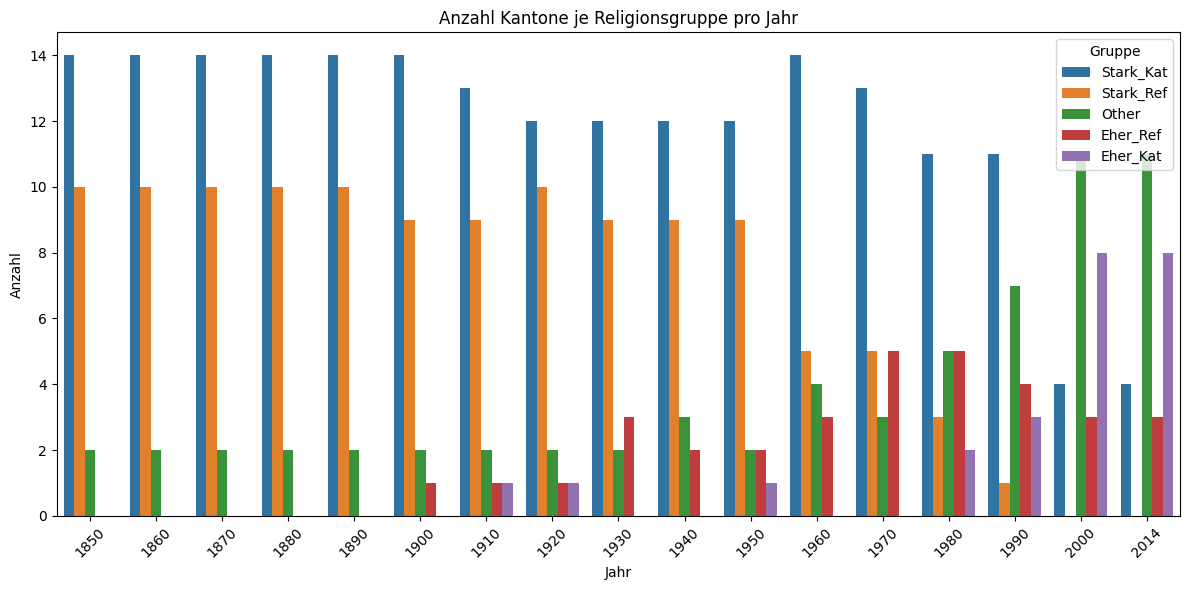

In [4]:


# DataFrame 'df_grouped' muss bereits existieren und folgendes enthalten:
# Spalten im Format "1850_Gruppe", "1860_Gruppe", ..., mit Werten wie 'Stark_Kat', 'Eher_Kat' etc.

# Schritt 1: Gruppenzählung vorbereiten
group_counts_per_year = pd.DataFrame()

for col in df_grouped.columns:
    year = col.replace("_Gruppe", "")
    counts = df_grouped[col].value_counts().rename_axis("Gruppe").reset_index(name="Anzahl")
    counts["Jahr"] = year
    group_counts_per_year = pd.concat([group_counts_per_year, counts], ignore_index=True)

# Schritt 2: Visualisierung
plt.figure(figsize=(12, 6))
sns.barplot(data=group_counts_per_year, x="Jahr", y="Anzahl", hue="Gruppe")
plt.title("Anzahl Kantone je Religionsgruppe pro Jahr")
plt.xticks(rotation=45)
plt.legend(title="Gruppe")
plt.tight_layout()
plt.show()


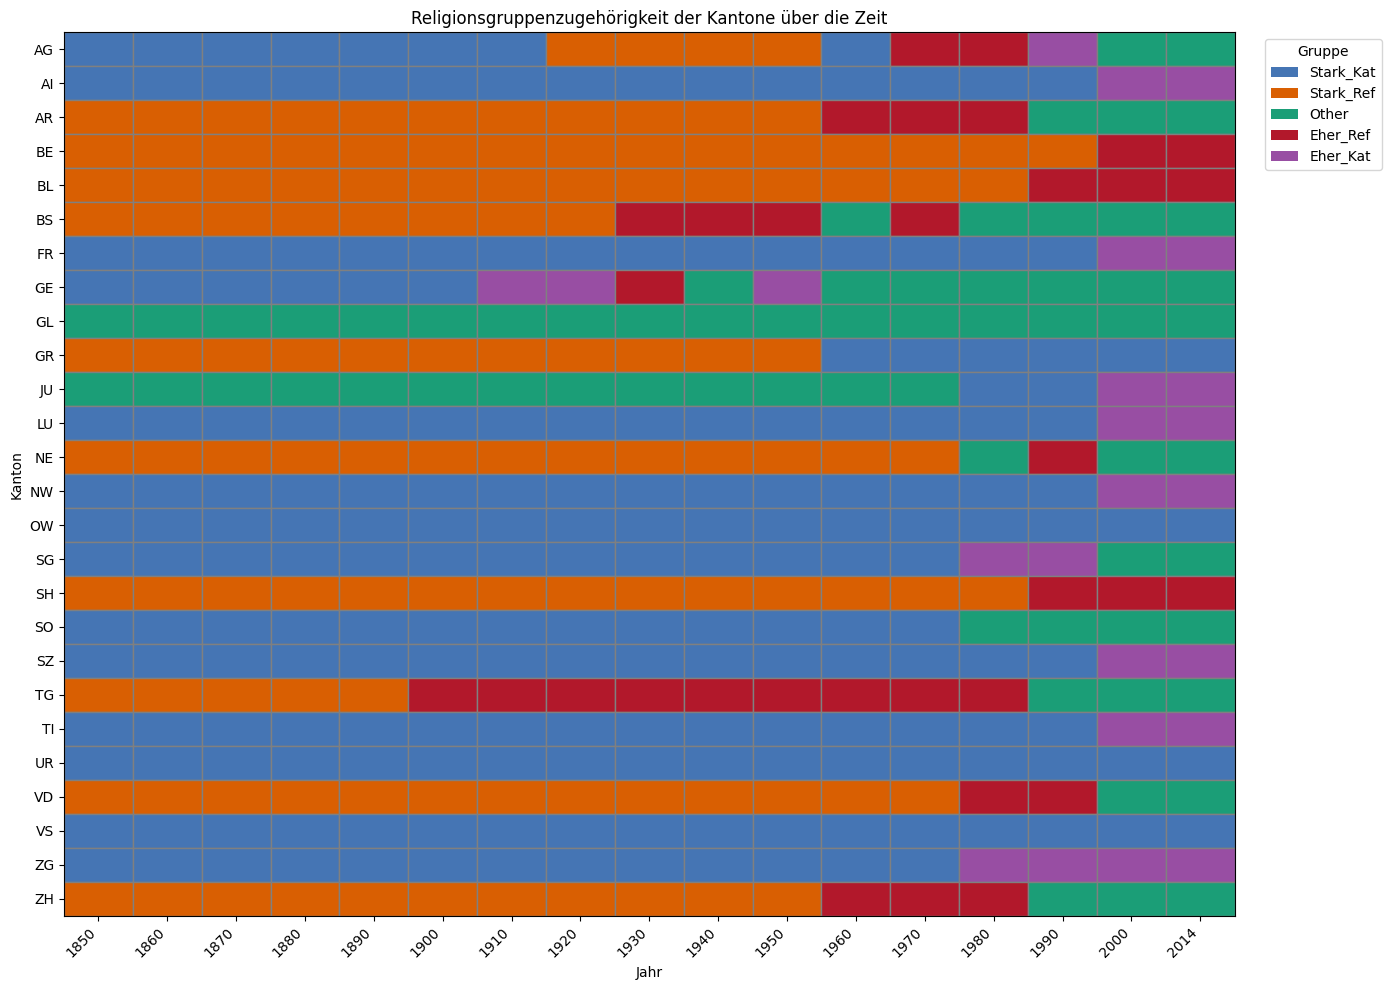

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. DataFrame vorbereiten (df_grouped muss vorher schon vorhanden sein)
group_heatmap = pd.DataFrame(index=df_grouped.index)
for jahr in sorted(df_grouped.columns):
    if jahr.endswith("_Gruppe"):
        year = jahr.replace("_Gruppe", "")
        group_heatmap[year] = df_grouped[jahr]

# 2. Farbdefinition gemäss deiner Legende
custom_group_colors = {
    'Stark_Kat': '#4575b4',   # Blau
    'Stark_Ref': '#d95f02',   # Orange
    'Other': '#1b9e77',       # Grün
    'Eher_Ref': '#b2182b',    # Rot
    'Eher_Kat': '#984ea3'     # Violett
}

# 3. Plot erstellen mit farbigen Rechtecken
fig, ax = plt.subplots(figsize=(14, 10))

kantone = group_heatmap.index.tolist()
jahre = group_heatmap.columns.tolist()

# Rechtecke für jede Zelle malen
for y_idx, kanton in enumerate(kantone):
    for x_idx, jahr in enumerate(jahre):
        gruppe = group_heatmap.loc[kanton, jahr]
        farbe = custom_group_colors.get(gruppe, "#ffffff")  # Weiß, wenn unbekannte Gruppe
        rect = plt.Rectangle((x_idx, y_idx), 1, 1, facecolor=farbe, edgecolor='gray')
        ax.add_patch(rect)

# 4. Achsen konfigurieren
ax.set_xlim(0, len(jahre))
ax.set_ylim(0, len(kantone))
ax.set_xticks([i + 0.5 for i in range(len(jahre))])
ax.set_xticklabels(jahre, rotation=45, ha="right")
ax.set_yticks([i + 0.5 for i in range(len(kantone))])
ax.set_yticklabels(kantone)
ax.invert_yaxis()
ax.set_title("Religionsgruppenzugehörigkeit der Kantone über die Zeit")
ax.set_xlabel("Jahr")
ax.set_ylabel("Kanton")

# 5. Legende manuell einfügen
legend_elements = [Patch(facecolor=color, label=label) for label, color in custom_group_colors.items()]
ax.legend(handles=legend_elements, title="Gruppe", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()

# 6. Optional speichern
plt.savefig("Religionsgruppen_Kanton_Jahr.png", dpi=300)
plt.show()
